100%|██████████| 170498071/170498071 [00:03<00:00, 51268802.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                  [-1, 128]         262,272
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 268,650
Trainable params: 268,650
Non-trainable params: 0
----------------------------------------------------------------
Input

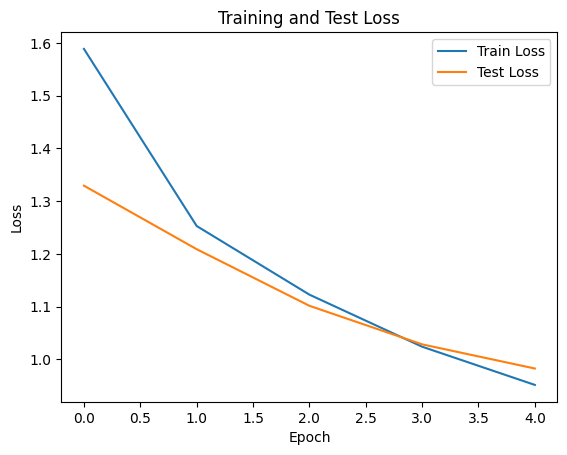

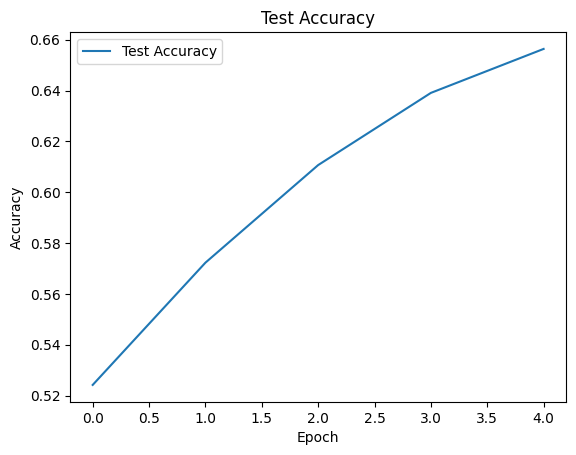

Accuracy on test set: 0.6564


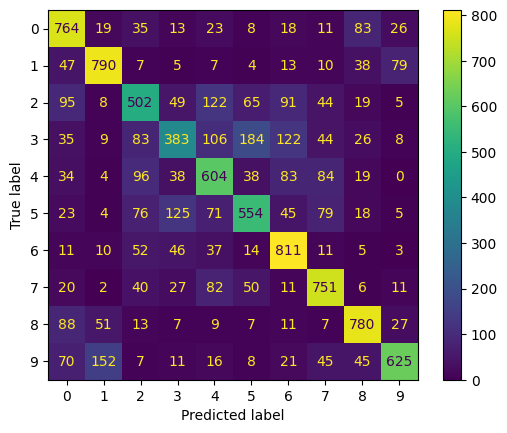

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(testset, batch_size=256, shuffle=False)

# Model Architecture
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32 * 8 * 8, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model.to()

# Model Summary
summary(model, (3, 32, 32))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing loop
def train(model, optimizer, criterion, num_epochs, train_loader, test_loader):
    history = {'train_loss': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(), labels.to()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(), labels.to()
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss /= len(test_loader.dataset)
        test_acc = correct / total
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {test_acc:.4f}")

    return history

# Train the model
num_epochs = 5
history = train(model, optimizer, criterion, num_epochs, train_loader, test_loader)

# Plotting functions for visualization
def plot_losses(history):
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.plot(history['test_acc'], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()
    plt.show()

plot_losses(history)
plot_accuracy(history)

# Testing accuracy and plotting confusion matrix
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(), labels.to()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy on test set: {accuracy:.4f}')

cm = confusion_matrix(true_labels, predicted_labels)
labels = range(10)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()